# Quality Control analyses of HPAP single-cell transcriptomic data
This notebook reports the QC analysis performed to select high-quality cells used in the manuscript **"The gene signatures of human alpha cells in types 1 and 2 diabetes indicate disease-specific pathways of alpha cell dysfunction"** (currently under revision, [preprint version available here](https://www.biorxiv.org/content/10.1101/2022.02.22.481528v1)). The QC analysis starts from the output of STAR, that is a table file reporting the number of mapped reads for each gene in each cell. In the first step, these tables are used to generate ADATA objects, which are then used to compute the metrics used for QC (that are number of mapped reads, number of expressed genes, and fraction of mitochondrial genes expressed). Since the HPAP samples display substantial variation in these metrics, the QC analysis is performed separately for each sample (as also recommended in the [best-practice paper by Luecken and Theis](https://www.embopress.org/doi/full/10.15252/msb.20188746)). Finally, the distributions of QC metrics are carefully evaluated to identify potential outliers (i.e. low quality cells) to be removed from downstream analyses.


In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
from gprofiler import gprofiler

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

/usr/local/lib/python3.6/dist-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.8 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.1.5 scikit-learn==0.21.3 statsmodels==0.12.0.dev0+57.g693c22e2e python-igraph==0.7.1 louvain==0.6.1


In [4]:
%%R
gc()
rm(list = ls())

# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(lme4)
#library(slingshot)
#library(monocle)
#library(gam)
#library(clusterExperiment)
library(ggplot2)
library(plyr)
library(MAST)

In [5]:
# Set up data loading

def makeSingleTable(files,outname,to_skip=None):
    """ merge the content of multiple *_ReadsPerGene.out.tab files in a single table. 
    The files should be the output of STAR, only the first column is considered.
    Note that the ERR identifier (or any cell-level identifier) should be included
    in the filename (eg ERRXXXXXXX_ReadsPerGene.out.tab). """
    import os
    identifiers = []
    if to_skip == None: to_skip = {}
    with open(outname,"w") as writer:
        for fi,f in enumerate(files):
            identifier = os.path.split(f)[-1].split("_fastq")[0]
            identifier = identifier.split("scRNA_")[1]
            if identifier in to_skip: continue
            identifiers += [identifier]
            with open(f) as fh:
                if fi == 0:
                    lines = [l.strip().split("\t")[:2] for i,l in enumerate(fh) if i>=4]
                    continue
                else:
                    for i,l in enumerate(fh):
                        if i<4: continue
                        lines[i-4].append(l.strip().split("\t")[1])
        writer.write("\t".join(identifiers) + "\n")
        for l in lines: writer.write("\t".join(l) + "\n")
            
def getSampleInformation(sdrf,df_index=None):
    """ retrieve information associated with each cell from a sdrf file.
    if df_index is provided, the single-row sdrf will be repeated to match the index of df """
    if type(df_index) == type(None): return pd.read_table(sdrf,sep='\t',index_col=0,squeeze=True)
    df1 = pd.read_table(sdrf,"\t",index_col=0)
    df2 = pd.DataFrame(index=df_index,columns=df1.columns)
    for i,c in enumerate(df1.columns):
        df2[c] = df1.iloc[0,i]
    return df2

def get_n_genes(adata):
    """ return number of genes with at least 1 mapping read """
    return (adata.X>0).sum(axis=1)

def get_n_counts(adata,genes_subset=None):
    """ return number of reads mapped to genes """
    if genes_subset == None: return np.sum(adata.X,axis=1)
    return np.sum(adata[:,genes_subset].X,axis=1)

def get_percent_mito(adata,mitochondrial_genes=None):
    """ return fraction of reads mapped to mitochondrial genes """
    if mitochondrial_genes == None: 
        mitochondrial_genes = [i.strip()
                               for i in open("hg19/annotation/ensembl/mitochondrial_genes.txt")]
    mito_count,all_count = get_n_counts(adata,mitochondrial_genes),get_n_counts(adata)
    return mito_count/all_count

def getSampleInformation(sdrf,df_index=None):
    """ retrieve information associated with each cell from a sdrf file.
    if df_index is provided, the single-row sdrf will be repeated to match the index of df """
    if type(df_index) == type(None): return pd.read_table(sdrf,sep='\t',index_col=0,squeeze=True)
    df1 = pd.read_table(sdrf,"\t",index_col=0)
    df2 = pd.DataFrame(index=df_index,columns=df1.columns)
    for i,c in enumerate(df1.columns):
        df2[c] = df1.iloc[0,i]
    return df2

def starSolo2Adata(sampleID,outDirectory):
    """ create a `Adata` object from STARSolo count table and sdrf infos computing all
    necessary QC metrics (number of genes, read counts, mitochondrial fraction) """
    import scipy as sp
    from scipy.io import mmread
    import pandas as pd
    import anndata as ad
    mtx,barcodes,features = "matrix.mtx","barcodes.tsv","features.tsv"
    X = sp.io.mmread(f'{outDirectory}/{mtx}')
    obs = pd.read_csv(f'{outDirectory}/{barcodes}', header=None, sep='\t', names = ["Barcode"])
    # obs["SampleID"] = sampleID
    var = pd.read_csv(f'{outDirectory}/{features}', header=None, sep='\t', names = ["EnsGeneID","GeneSymbol"])
    var.index = var.iloc[:,0].values
    adata = ad.AnnData(X.T.todense(),obs=obs,var=var)
    df_ = pd.read_table(f"{outDirectory}/{sampleID}.tsv",header=0,index_col=0)
    # df_ = pd.read_table(f"/home/bosi/analisi/panalphat2d/sdrf_files/{sampleID}.tsv",header=0,index_col=0)
    cols,vals = df_.columns,df_.iloc[0].values
    for c,v in zip(cols,vals): adata.obs[c] = v
    n_genes,n_counts,percent_mito = map(lambda x: x(adata),
                                        [get_n_genes,get_n_counts,get_percent_mito])
    for label,value in zip(("n_genes","n_counts","percent_mito"),
                           (n_genes,n_counts,percent_mito)):
        adata.obs[label] = value
    return adata

def countTable2Adata(countTable,sdrf):
    """ create a `Adata` object from STAR count table and sdrf infos computing all
    necessary QC metrics (number of genes, read counts, mitochondrial fraction) """
    count_df = pd.read_table(countTable,index_col=0,header=0,engine="python",sep="\t")
    X = count_df.T.apply(pd.to_numeric)
    obs_idxs = count_df.columns
    obs = getSampleInformation(sdrf,X.index)
    var = pd.DataFrame(index=count_df.index)
    var["ids"] = var.index.values
    adata = ad.AnnData(X,obs=obs,var=var)
    n_genes,n_counts,percent_mito = map(lambda x: x(adata),
                                        [get_n_genes,get_n_counts,get_percent_mito])
    for label,value in zip(("n_genes","n_counts","percent_mito"),
                           (n_genes,n_counts,percent_mito)):
        adata.obs[label] = value
    return adata

# QC diagnostic


here we plot the expressed genes, number of reads and mitochondrial fraction separately for each sample, trying to evaluate how these covariate to define threshold criteria to remove low-quality cells.
Plots shown will be:
- 3 QC metrics for each sample (violinplots)
- 7 samples for each QC metric (boxplots)
- 1 QC covariation plot for each sample (jointplots)
- 3 plots rank-vs-QC metric for each sample (scatterplots)
- tails of the QC distributions (histograms)

Note that, to simplify the notebook, the analysis of tails (done for all samples) is reported here only for one sample.  

## Analysis of the T1D dataset

### T1D 

In [6]:
# step 1: read the output of STARsolo to produce 1 adata object for each sample
ids_fluidigm = ['HPAP-015']
ids_10X = ['HPAP-020','HPAP-021','HPAP-023','HPAP-028','HPAP-032','HPAP-055']

adatas_fluidigm_t1d = [countTable2Adata(f"data/fluidigm/count_tables/{id}_scRNA.merged.counts.tsv",
                                   f"data/fluidigm/sdrf_files/{id}.tsv")
                  for id in ids_fluidigm]
adatas_10X_t1d = [starSolo2Adata(id,f"data/10X/{id}")
                 for id in ids_10X]

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


at this point we have the adata objects containing the single-cell data (one for each sample).
We need to:
- perform a diagnostic QC plot using the number of expressed genes, number of reads and mitochondrial fraction
- define thresholds, apply them and merge the filtered adata objects

In [7]:
import warnings
warnings.filterwarnings('ignore')

def violinPlots(adata,title):
    """ for each sample plot the 3 QC plot """
    id_vars = [i for i in adata.obs.columns.values if i not in {'n_genes', 'n_counts', 'percent_mito'}]
    melted = adata.obs.melt(id_vars=id_vars)
    g = sb.FacetGrid(melted, col="variable",sharey=False,sharex=False)
    g.map(sb.violinplot,"value",color="lightblue")
    g.map(sb.stripplot,"value",linewidth=1,alpha=0.4)
    g.fig.suptitle(title,y=1.05)
    for ax, title in zip(g.axes.flat, ['number of expressed genes',
                                       'number of read counts',
                                       'mitochondrial fraction']):
        ax.set_title(title)

def depthxRankPlot(ad,var,**kwargs):
    """ plot the ranked n_counts of adata `ad` """
    import seaborn as sns
    v1 = ad.obs.sort_values(by=var)[var]
    v2 = range(len(v1))
    df = pd.DataFrame({var:v1,"rank":v2,"hue":v2})
    #sns.scatterplot("rank",var,hue="hue",data=df,**kwargs)
    sns.scatterplot("rank",var,data=df,**kwargs)

def rankPlots(ad,title):
    """ scatter plots of ranked n_genes and n_counts """
    f,ax = plt.subplots(1,3)
    f.suptitle(title,y=1.05)
    depthxRankPlot(ad,"n_genes",alpha=0.8,ax=ax[0])
    depthxRankPlot(ad,"n_counts",alpha=0.8,ax=ax[1])
    depthxRankPlot(ad,"percent_mito",alpha=0.8,ax=ax[2])
    plt.tight_layout()
    plt.show()
    
def addNullPoint(ad):
    """ add a null point with mit. fraction = 1 to uniform scales across dataframes """
    return ad.obs.append({'percent_mito' : 1,'n_counts':0, 'n_genes':0},
                         ignore_index=True)

def jointPlot(ad,title,xlim=None,ylim=None,hist_col=None,magnitude="K",palette="viridis"):
    import seaborn as sns
    df = addNullPoint(ad)
    if xlim!=None: df = df[df['n_counts']<xlim]
    df = df[df['percent_mito']<=1]
    grid = sns.JointGrid(x='n_counts', y='n_genes', data=df)
    g = grid.plot_joint(sns.scatterplot, hue='percent_mito', data=df,palette=palette, linewidth=0,alpha=0.8)
    ax_x = sns.distplot(df['n_counts'], ax=g.ax_marg_x,color=hist_col)
    ax_y = sns.distplot(df['n_genes'], ax=g.ax_marg_y, vertical=True,color=hist_col)
    ax_x.set(xlabel='', ylabel='')
    ax_y.set(xlabel='', ylabel='')
    g.set_axis_labels(xlabel='Read counts',ylabel='Number of genes')
    if xlim==None: g.ax_marg_x.set_xlim(0,g.ax_marg_x.get_xlim()[1])
    else: g.ax_marg_x.set_xlim(0,xlim)
    #g.ax_marg_x.set_xlim(0,150000)
    if ylim==None: g.ax_marg_y.set_ylim(0,g.ax_marg_y.get_ylim()[1])
    else: g.ax_marg_y.set_ylim(0,ylim)
    #g.ax_marg_y.set_ylim(0,10000)
    if magnitude == "K": mag_n = 1000.
    else: mag_n = 1000000.
    xlabels = ['{:.1f}'.format(x) + magnitude for x in g.ax_joint.get_xticks()/mag_n]
    g.ax_joint.set_xticklabels(xlabels)
    new_labels = ["0-0.25","0.25-0.50","0.50-0.75","0.75-1"]
    handles, labels = g.ax_joint.get_legend_handles_labels()
    g.ax_joint.legend(handles=handles[1:], labels=new_labels,title="Mit. fraction")
    g.fig.suptitle(title,y=1.05)
    #print(legend.texts)
    #leg.texts

def allPlots(adatas,ids,prefix="figures/QC/T1D.",nFluidigm=1):
    # distributions of each variable, for each sample
    for id_,adata in zip(ids,adatas): violinPlots(adata,id_)
    plt.savefig(f"{prefix}.manta_distributions.pdf")
    # distributions of each sample, for each variable
    melted = pd.concat([a.obs.rename(columns={"HPAP_id":"SampleID"}).loc[:,["SampleID","n_genes","n_counts","percent_mito"]]
            for a in adatas]).melt(id_vars=["SampleID"])
    g = sb.catplot(x="SampleID", y="value",row="variable",sharey=False,data=melted, kind="box",aspect=2)
    for ax, title in zip(g.axes.flat, ['number of expressed genes','number of read counts','mitochondrial fraction']):
        ax.set_title(title)
    plt.savefig(f"{prefix}.QC_barplots.pdf")
    # same as above, but with no fluidigm samples
    melted = pd.concat([a.obs.rename(columns={"HPAP_id":"SampleID"}).loc[:,["SampleID","n_genes","n_counts","percent_mito"]]
            for a in adatas[nFluidigm:]]).melt(id_vars=["SampleID"])
    g = sb.catplot(x="SampleID", y="value",row="variable",sharey=False,data=melted, kind="box",aspect=2)
    for ax, title in zip(g.axes.flat, ['number of expressed genes','number of read counts','mitochondrial fraction']):
        ax.set_title(title)
    plt.savefig(f"{prefix}.QC_barplots.10X_only.pdf")
    # rankplots
    for id_,adata in zip(ids,adatas): rankPlots(adata,id_)
    plt.savefig(f"{prefix}.rankplots.pdf")
    # jointplots
    for id_,adata in zip(ids,adatas): jointPlot(adata,id_)
    plt.savefig(f"{prefix}.jointplots.pdf")


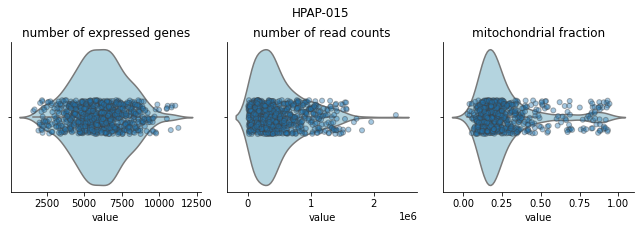

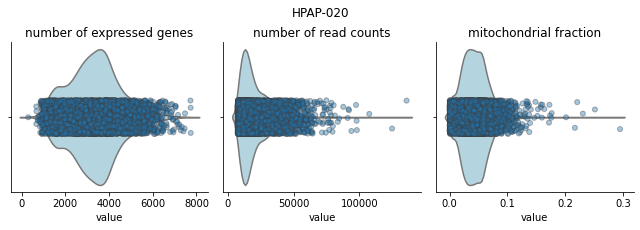

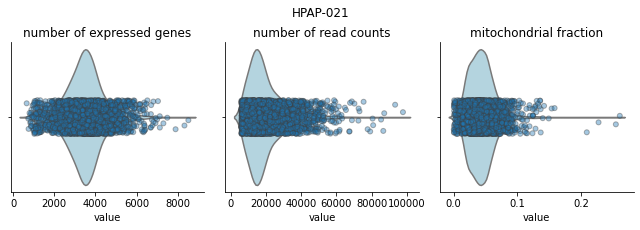

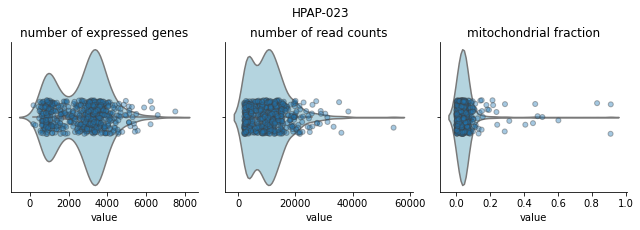

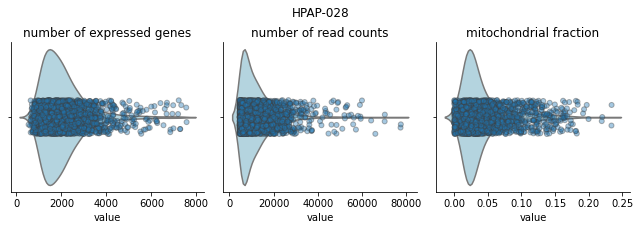

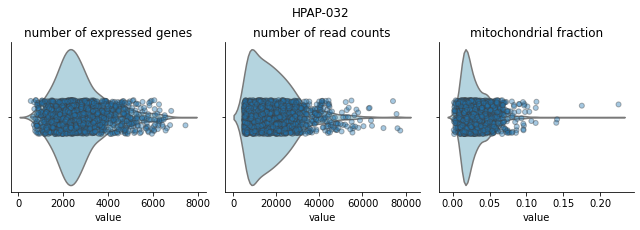

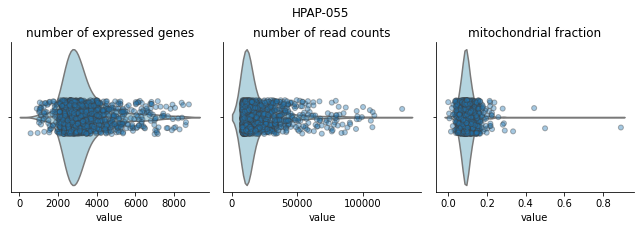

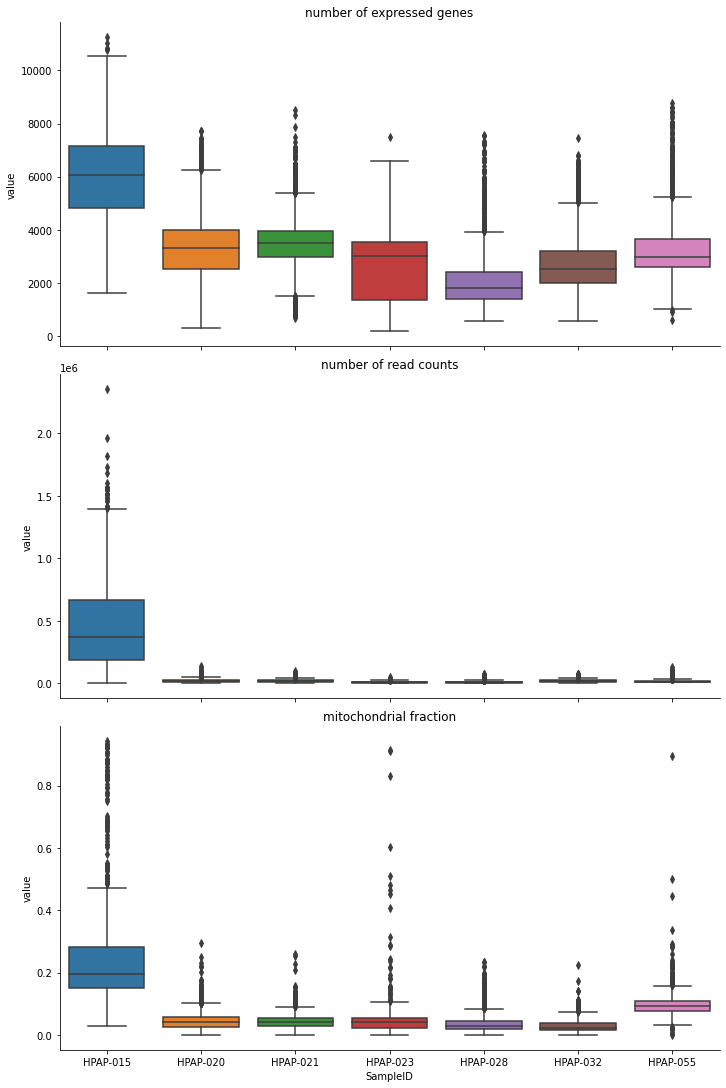

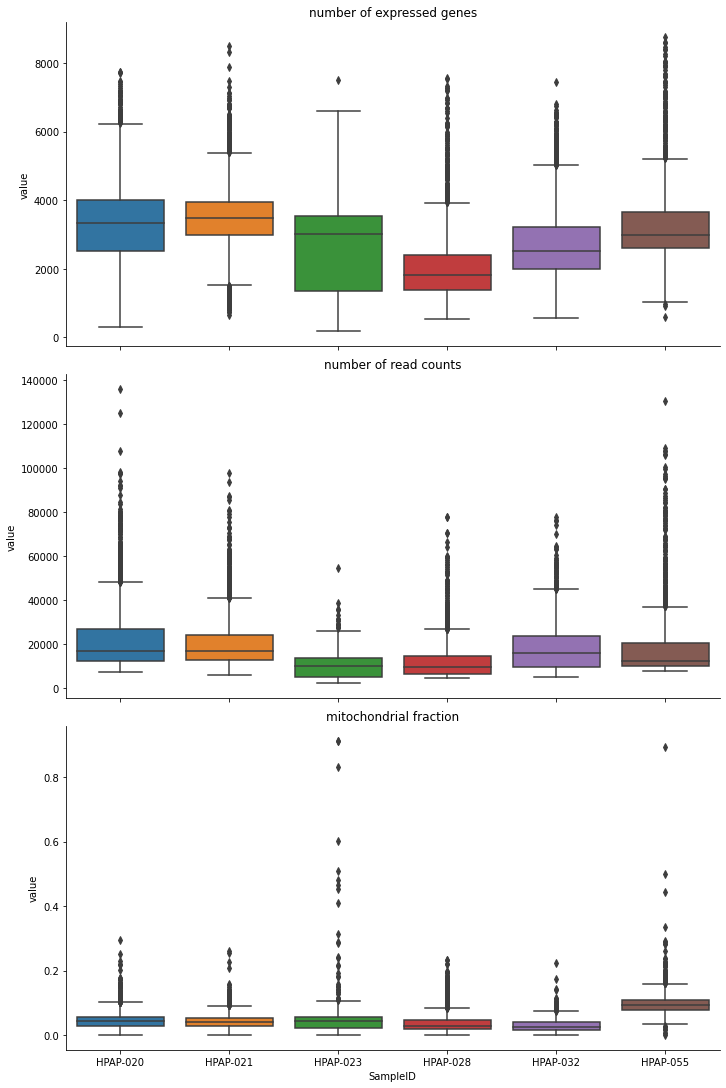

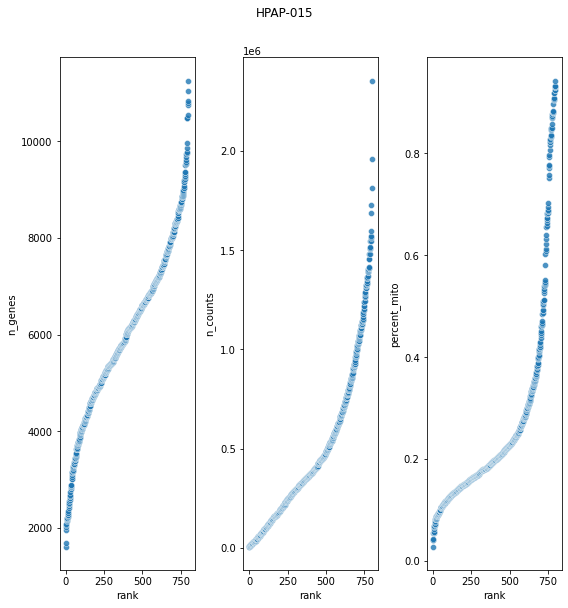

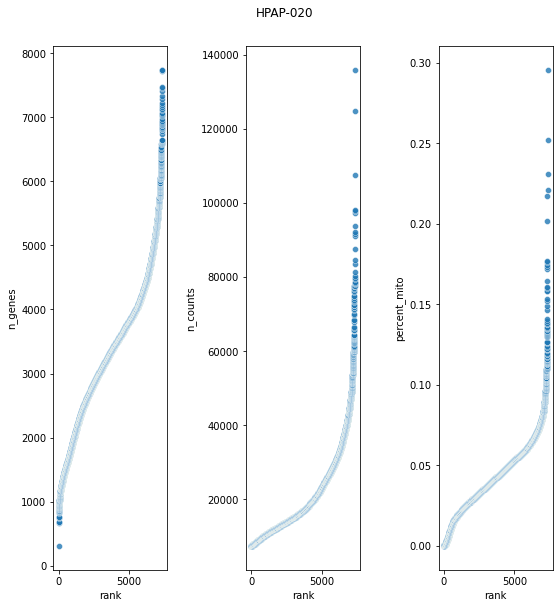

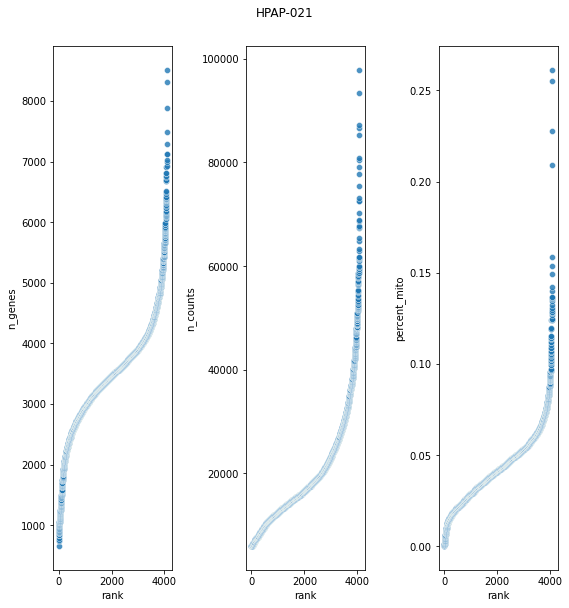

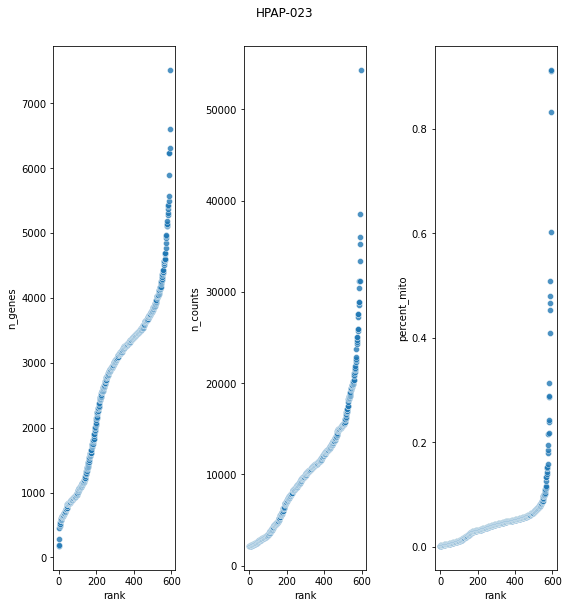

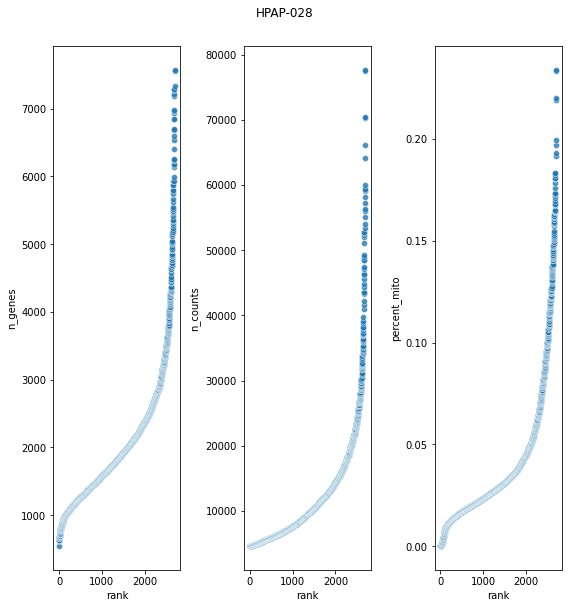

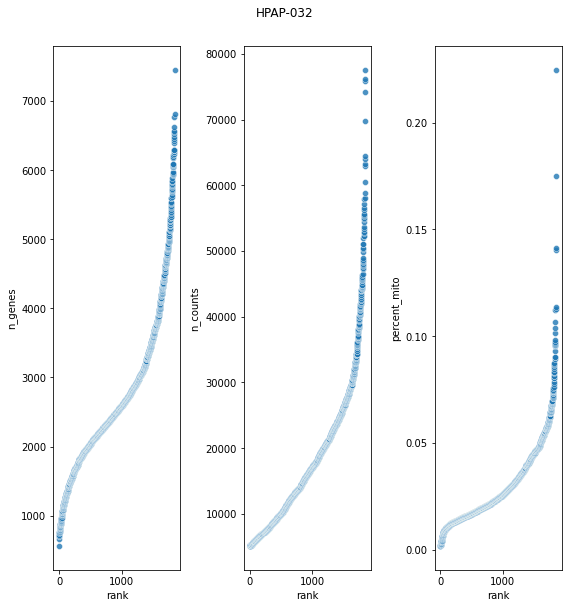

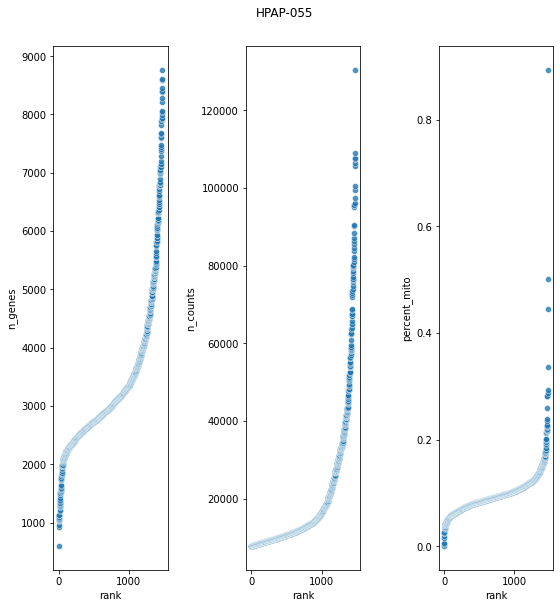

<Figure size 576x576 with 0 Axes>

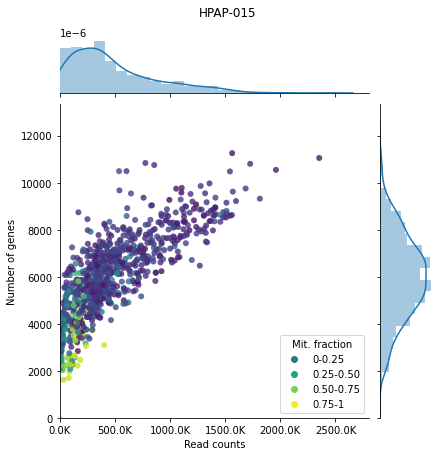

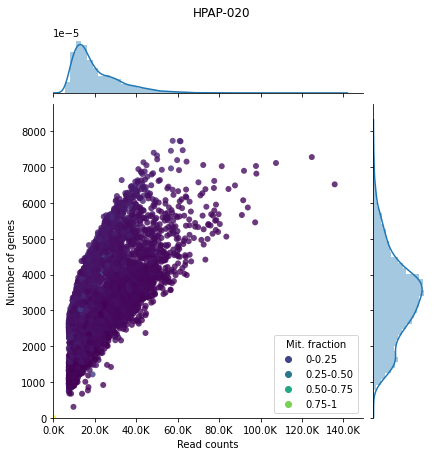

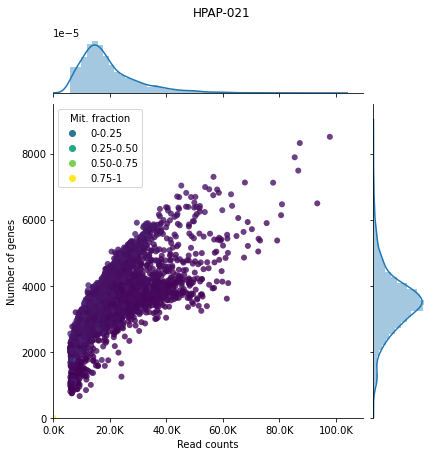

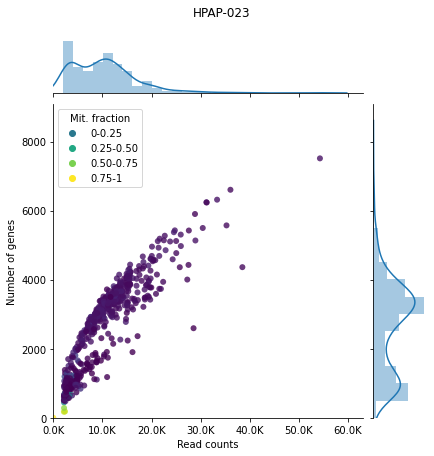

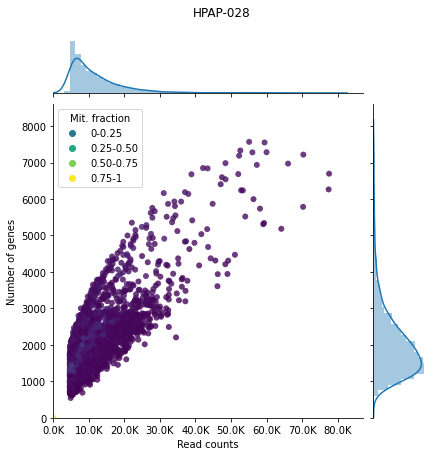

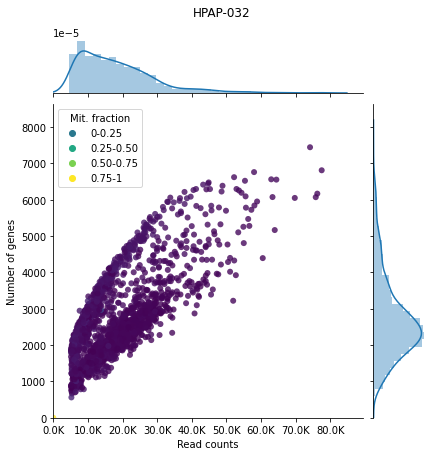

In [8]:
adatas_t1d = adatas_fluidigm_t1d + adatas_10X_t1d
ids_t1d = ids_fluidigm + ids_10X
allPlots(adatas_t1d,ids_t1d)

Extreme values distributions of QC parameters

#### Read counts
left

In [9]:
sb.displot(adatas_t1d[0].obs[adatas_t1d[0].obs["n_counts"]<=1000000],x="n_counts") # HPAP-015

right

In [10]:
sb.displot(adatas_t1d[0].obs[adatas_t1d[0].obs["n_counts"]>=1000000],x="n_counts") # HPAP-015

#### Number of genes
left

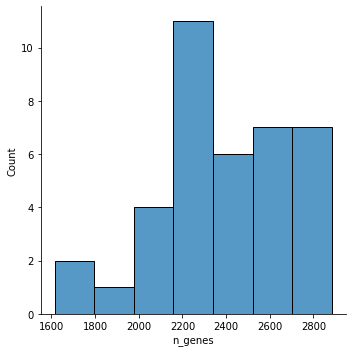

In [11]:
sb.displot(adatas_t1d[0].obs[adatas_t1d[0].obs["n_genes"]<=3000],x="n_genes") # HPAP-015

right

In [12]:
sb.displot(adatas_t1d[0].obs[adatas_t1d[0].obs["n_genes"]>=8000],x="n_genes") # HPAP-015

### ND donors matching T1D

In [13]:
### ND.T1D
# step 1: read the output of STARsolo to produce 1 adata object for each sample

ids_fluidigm = ['HPAP-012']
ids_10X = ['HPAP-034','HPAP-036','HPAP-039','HPAP-052','HPAP-056']

adatas_fluidigm_ndt1d = [countTable2Adata(f"data/fluidigm/count_tables/{id}_scRNA.merged.counts.tsv",
                                   f"data/fluidigm/sdrf_files/{id}.tsv")
                  for id in ids_fluidigm]
adatas_10X_ndt1d = [starSolo2Adata(id,f"data/10X/{id}")
                 for id in ids_10X]

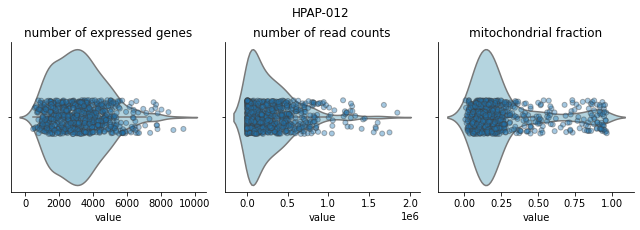

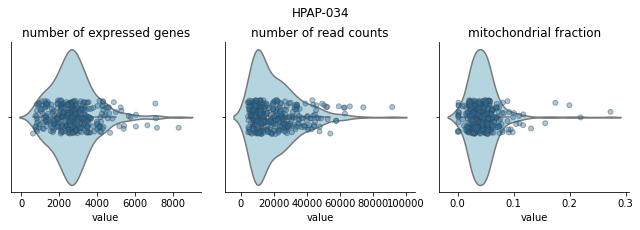

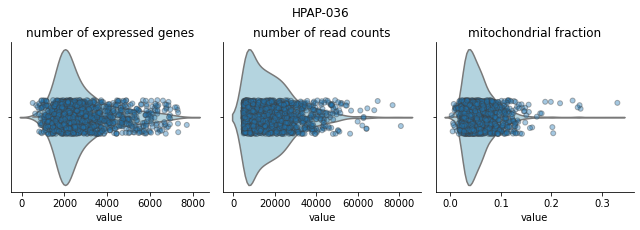

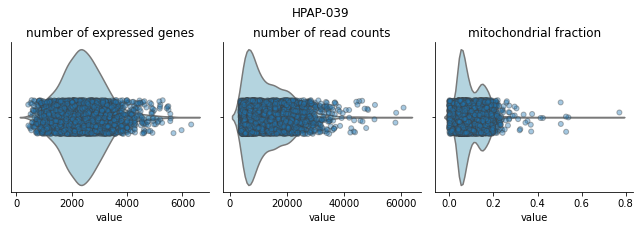

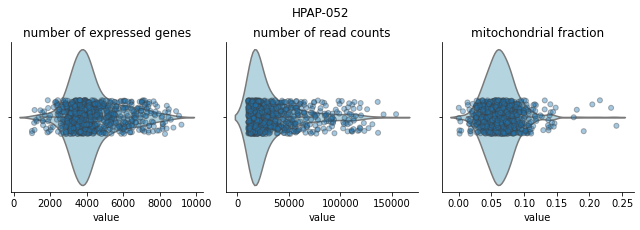

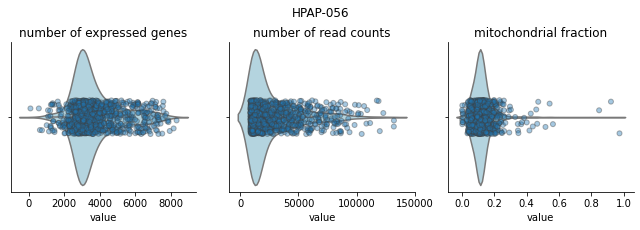

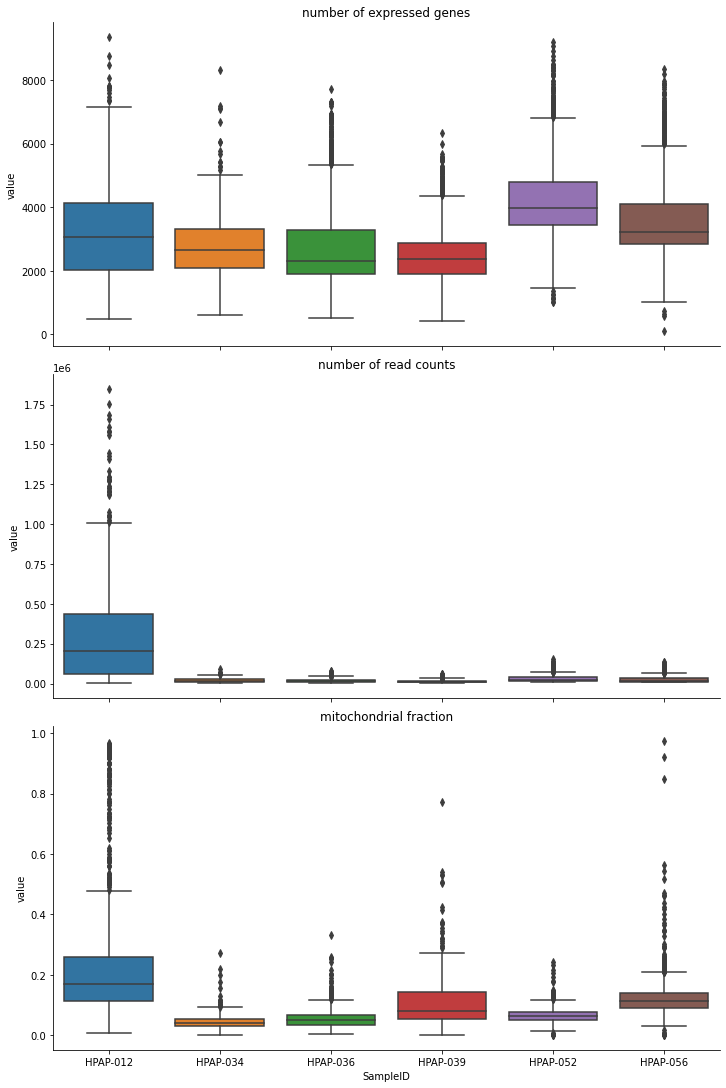

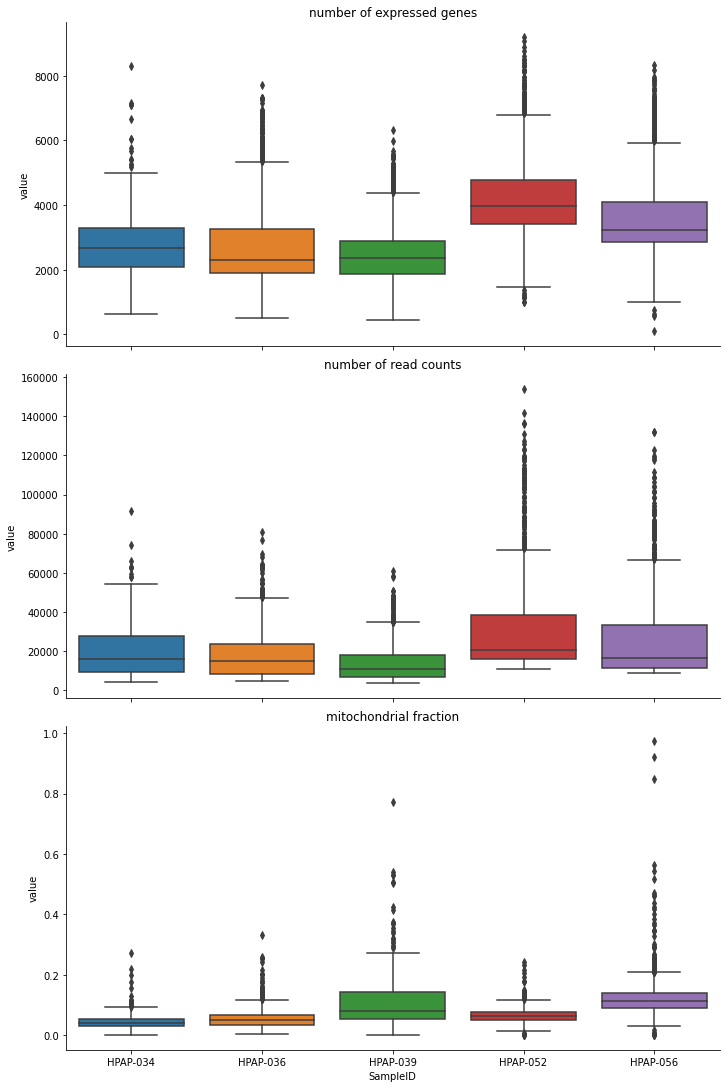

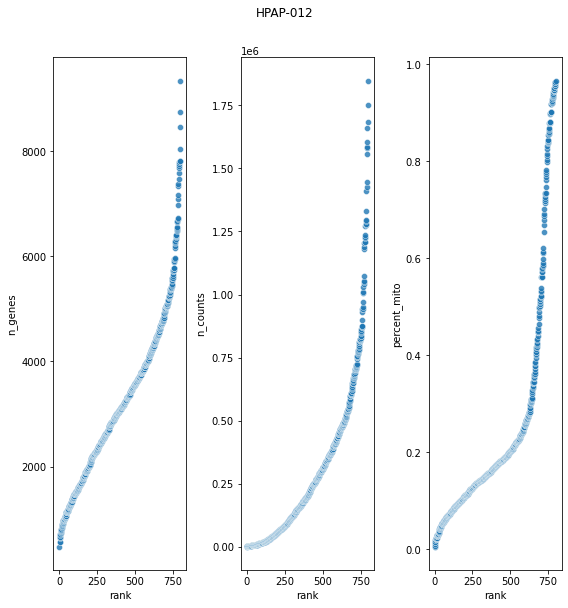

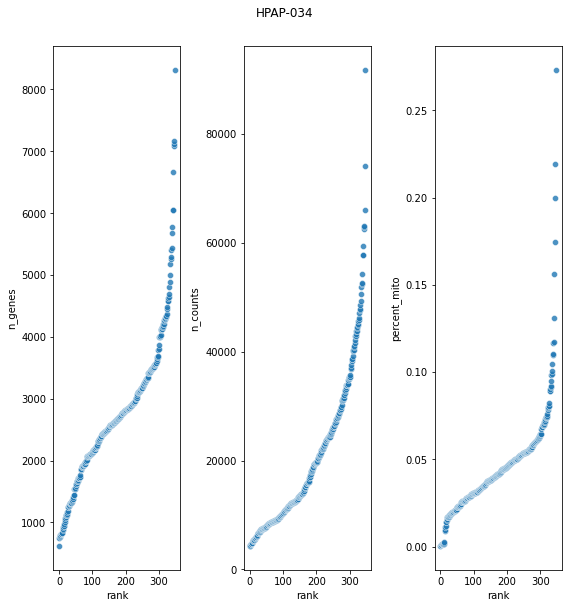

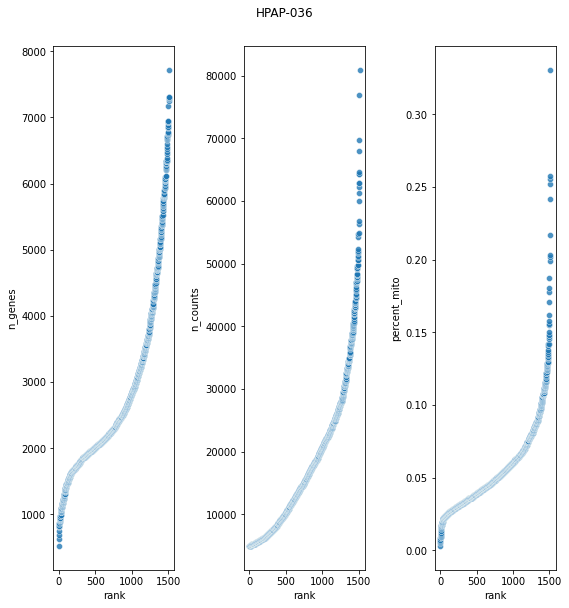

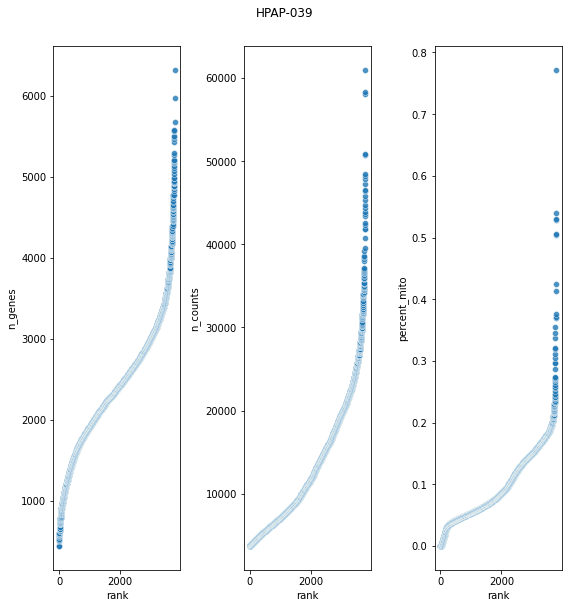

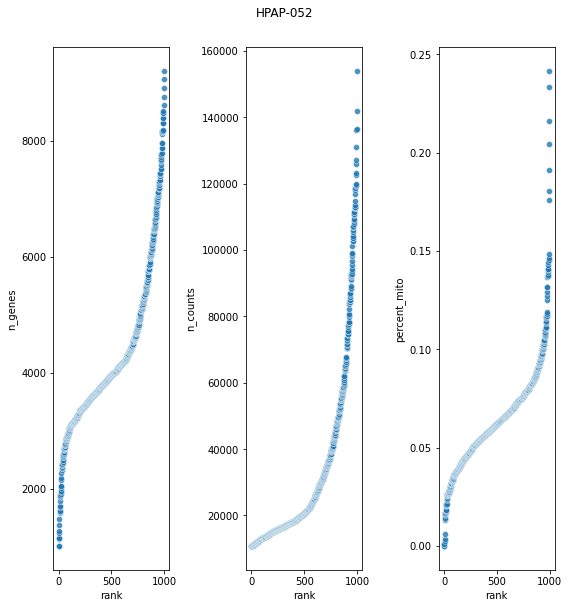

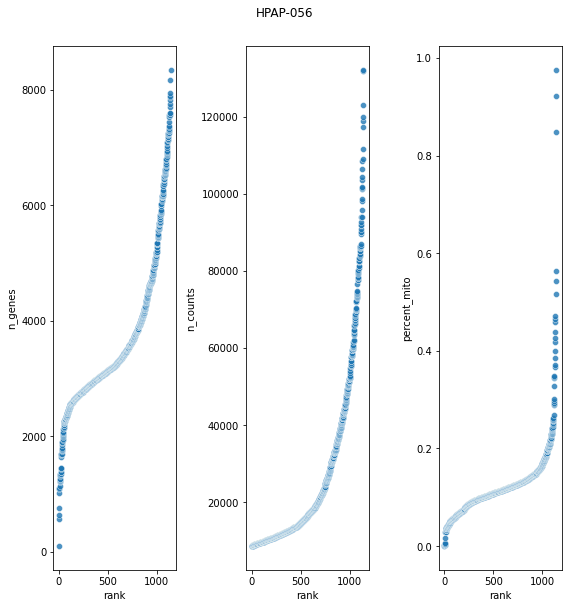

<Figure size 576x576 with 0 Axes>

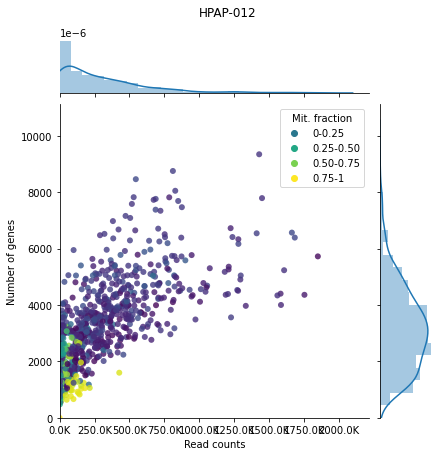

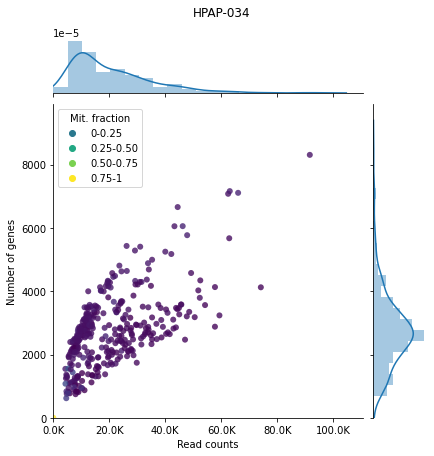

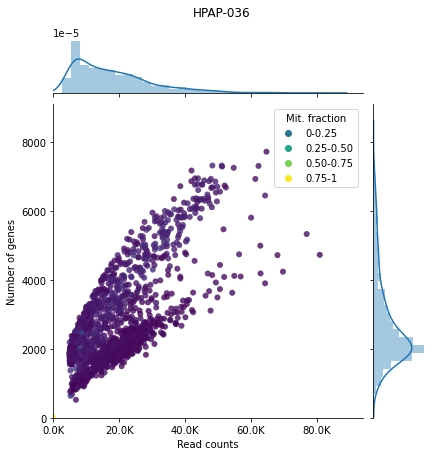

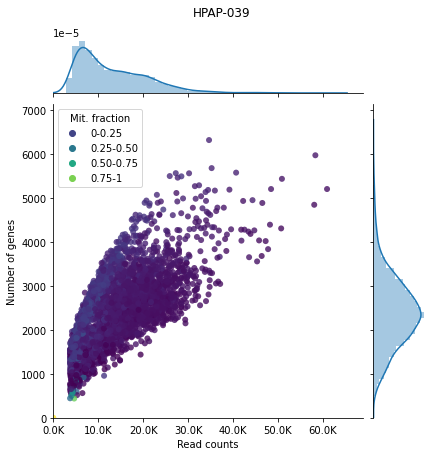

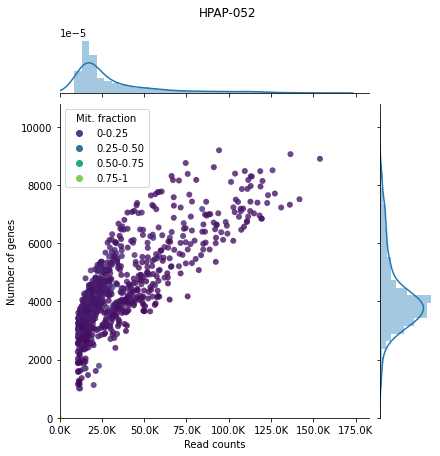

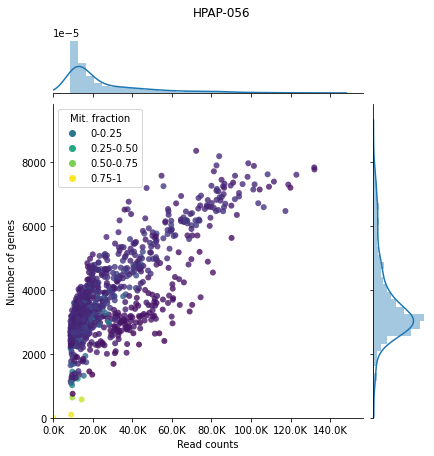

In [14]:
adatas_ndt1d = adatas_fluidigm_ndt1d + adatas_10X_ndt1d
ids_ndt1d = ids_fluidigm + ids_10X
allPlots(adatas_ndt1d,ids_ndt1d,prefix="figures/QC/ND.T1D")

## Analysis of the T2D dataset

### T2D

In [15]:
# T2D
import os

ids_fluidigm = ['HPAP-001','HPAP-007']
ids_10X = ['HPAP-051','HPAP-057','HPAP-058']

# for i in ids_fluidigm:
#     outname = f"/storage/analisi/panalphat2d/count_tables/{i}_scRNA.merged.counts.tsv"
#     makeSingleTable([f"/home/bosi/analisi/HPAP/{i}/{j}" 
#                      for j in os.listdir(f"/home/bosi/analisi/HPAP/{i}")
#                         if j.endswith("ReadsPerGene.out.tab")],outname,to_skip=None)

adatas_fluidigm_t2d = [countTable2Adata(f"data/fluidigm/count_tables/{id}_scRNA.merged.counts.tsv",
                                   f"data/fluidigm/sdrf_files/{id}.tsv")
                  for id in ids_fluidigm]
adatas_10X_t2d = [starSolo2Adata(id,f"data/10X/{id}")
                 for id in ids_10X]

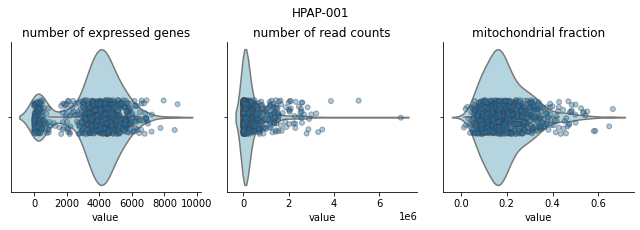

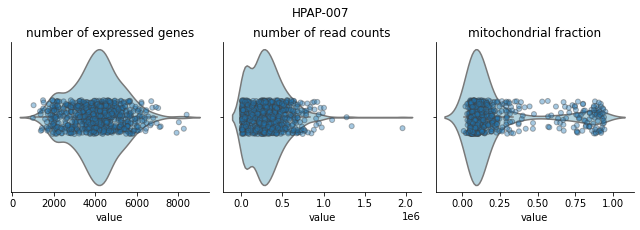

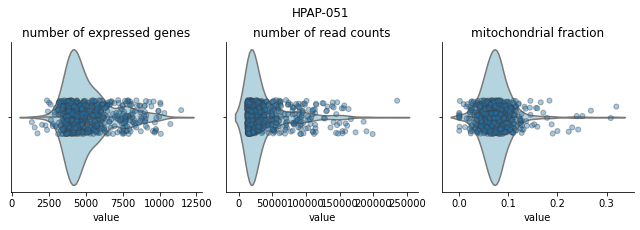

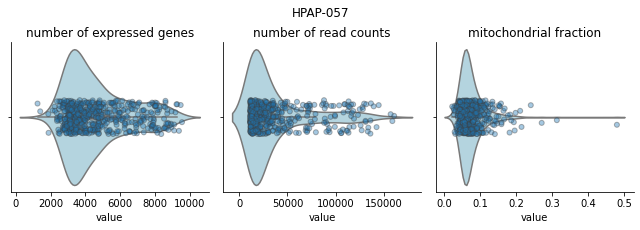

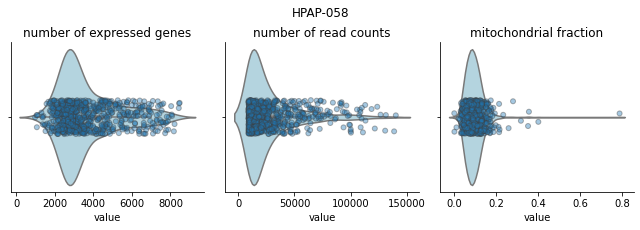

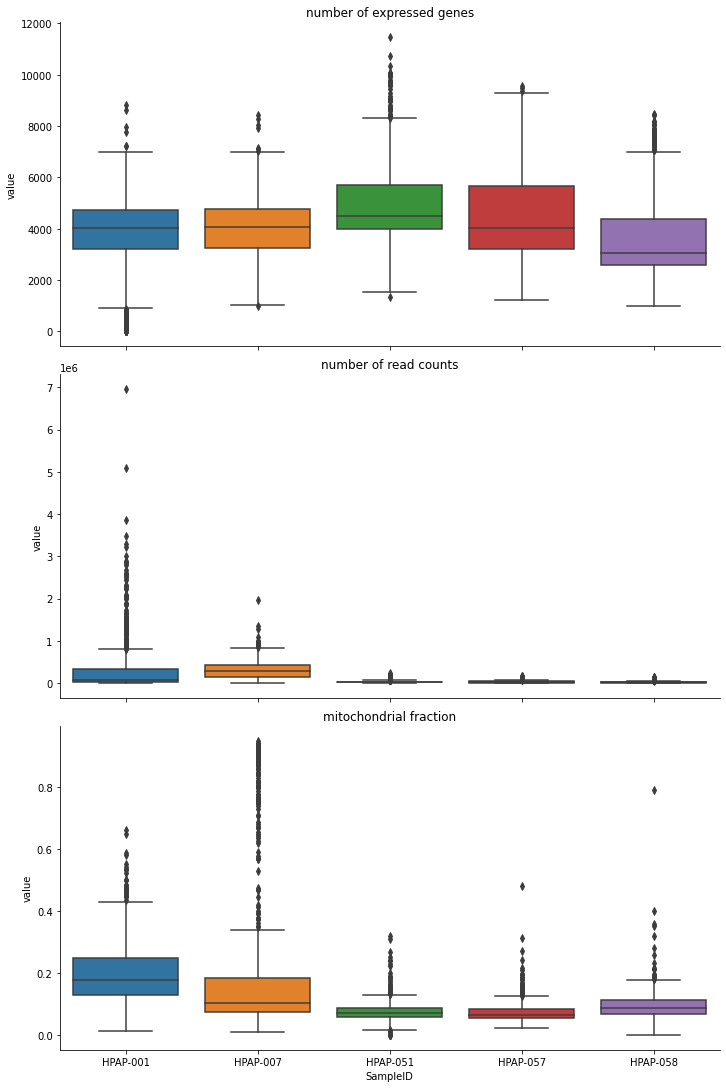

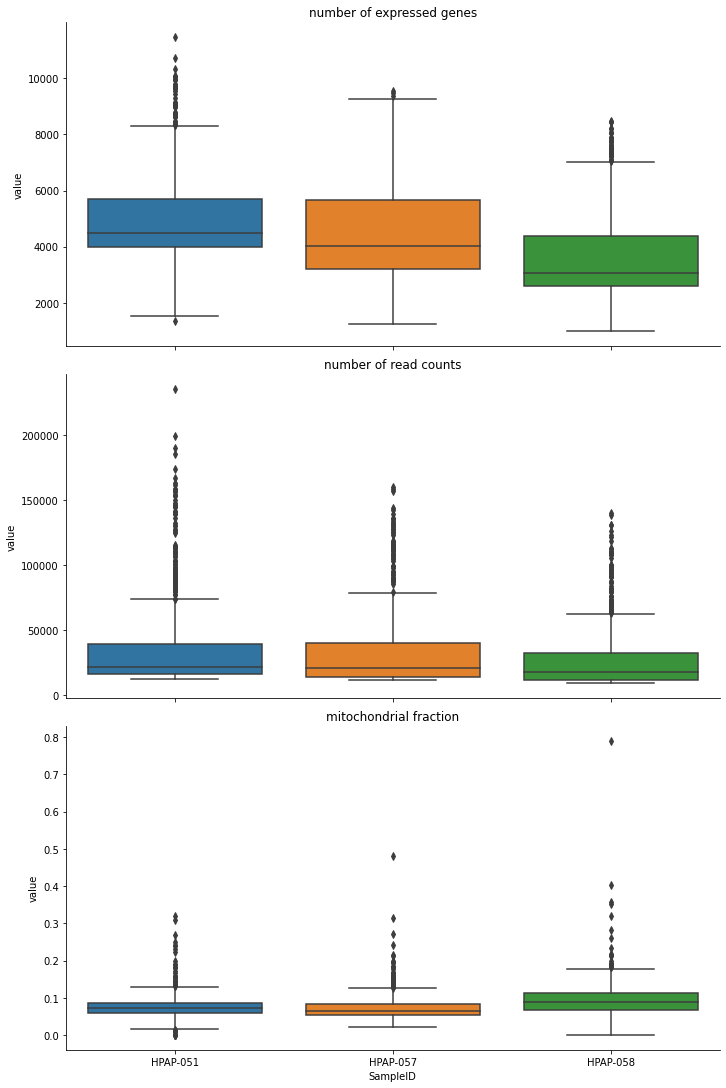

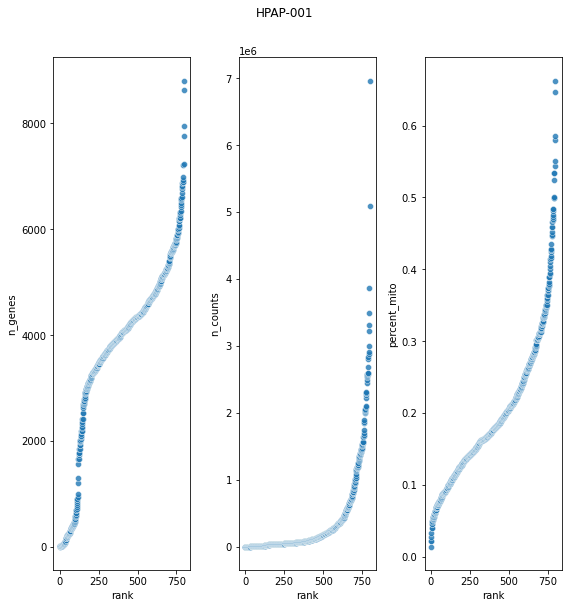

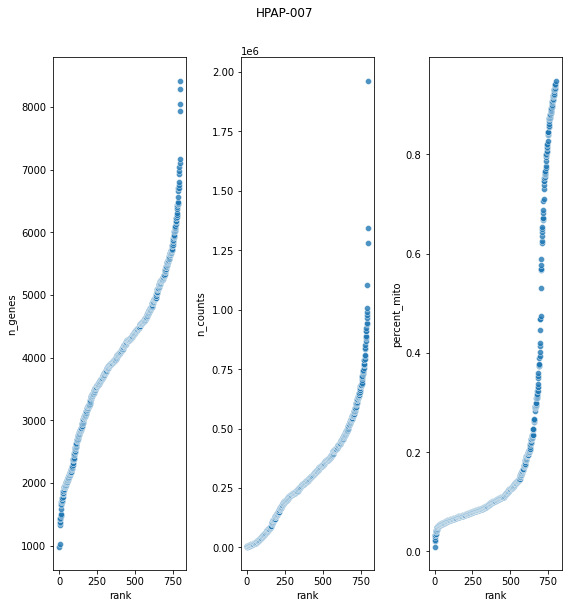

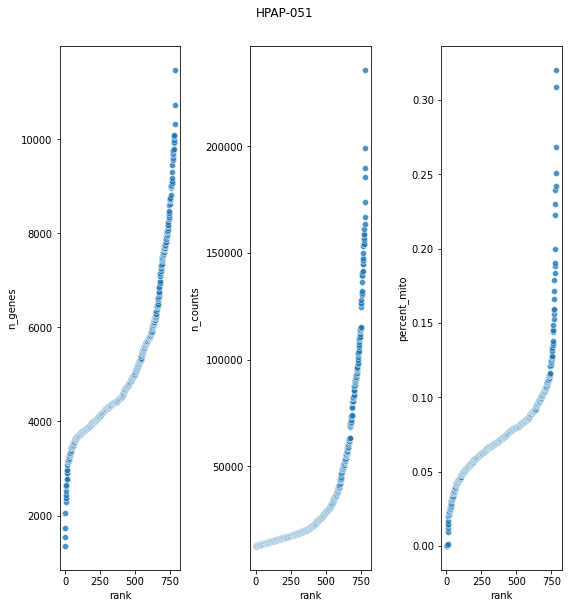

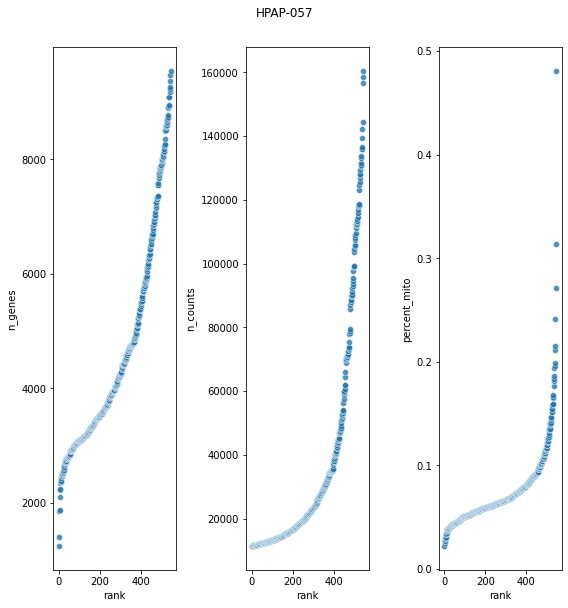

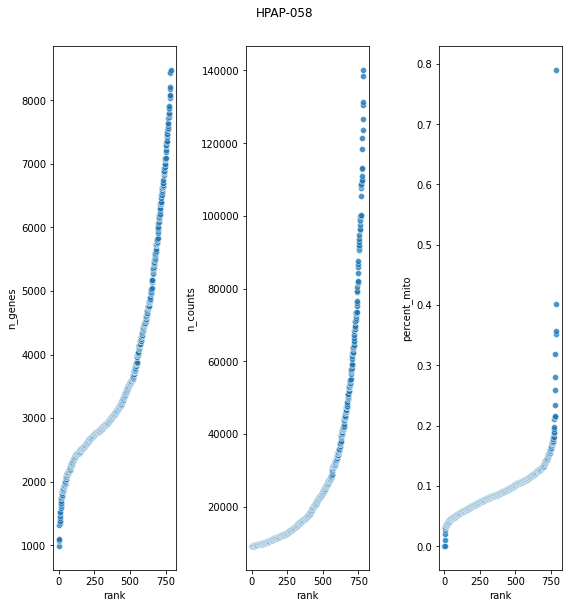

<Figure size 576x576 with 0 Axes>

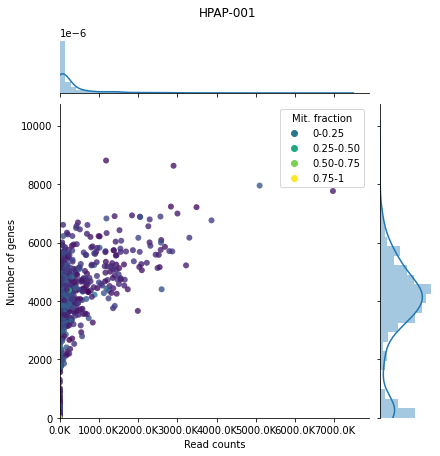

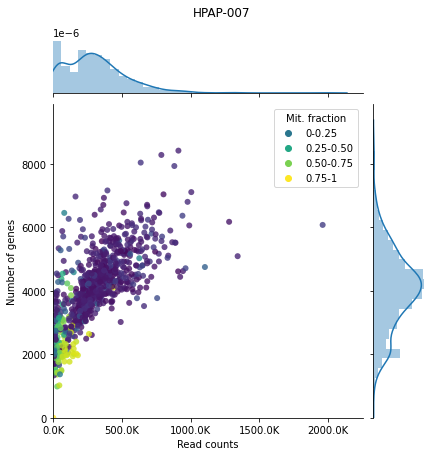

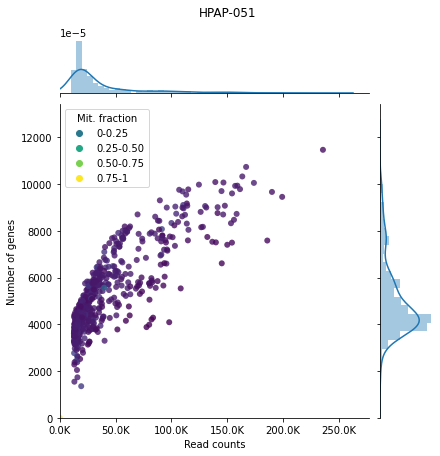

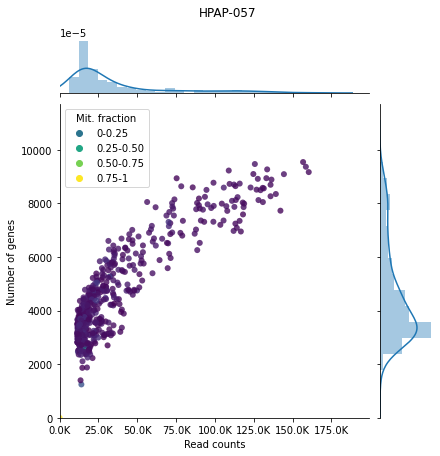

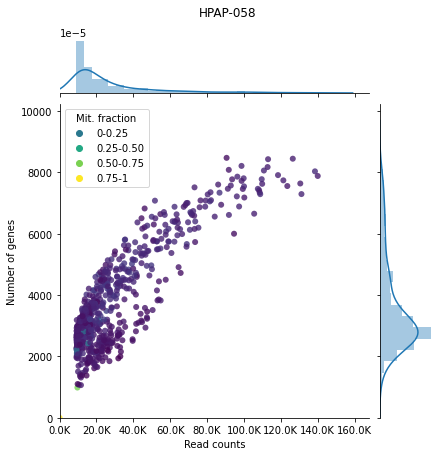

In [16]:
adatas_t2d = adatas_fluidigm_t2d + adatas_10X_t2d
ids_t2d = ids_fluidigm + ids_10X
allPlots(adatas_t2d,ids_t2d,prefix="figures/QC/T2D",nFluidigm=2)

### ND donors matching T2D

In [17]:
# ND
ids_fluidigm = ['HPAP-006','HPAP-014']
ids_10X = ['HPAP-053','HPAP-054','HPAP-059']

# for i in ids_fluidigm:
#     outname = f"/storage/analisi/panalphat2d/count_tables/{i}_scRNA.merged.counts.tsv"
#     makeSingleTable([f"/home/bosi/analisi/HPAP/{i}/{j}" 
#                      for j in os.listdir(f"/home/bosi/analisi/HPAP/{i}")
#                         if j.endswith("ReadsPerGene.out.tab")],outname,to_skip=None)

adatas_fluidigm_t2dnd = [countTable2Adata(f"data/fluidigm/count_tables/{id}_scRNA.merged.counts.tsv",
                                   f"data/fluidigm/sdrf_files/{id}.tsv")
                  for id in ids_fluidigm]
adatas_10X_t2dnd = [starSolo2Adata(id,f"data/10X/{id}")
                 for id in ids_10X]

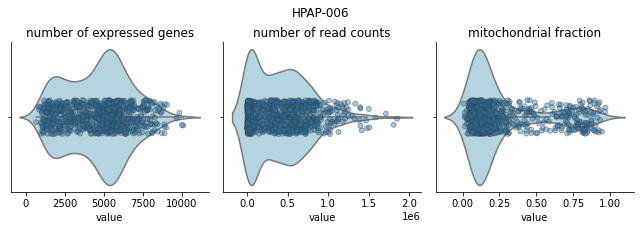

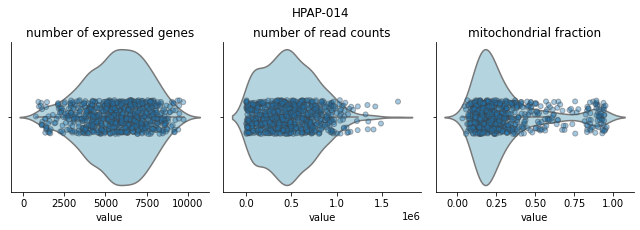

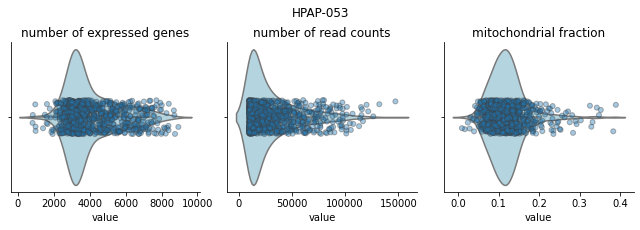

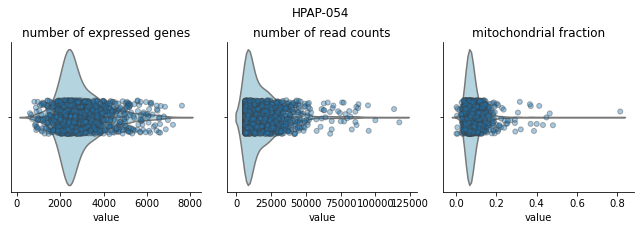

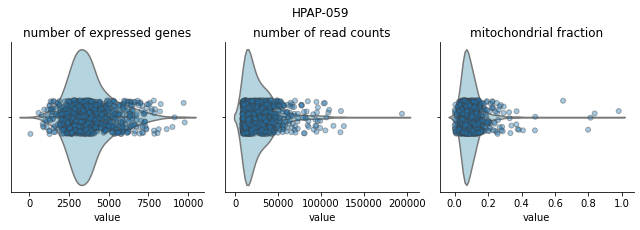

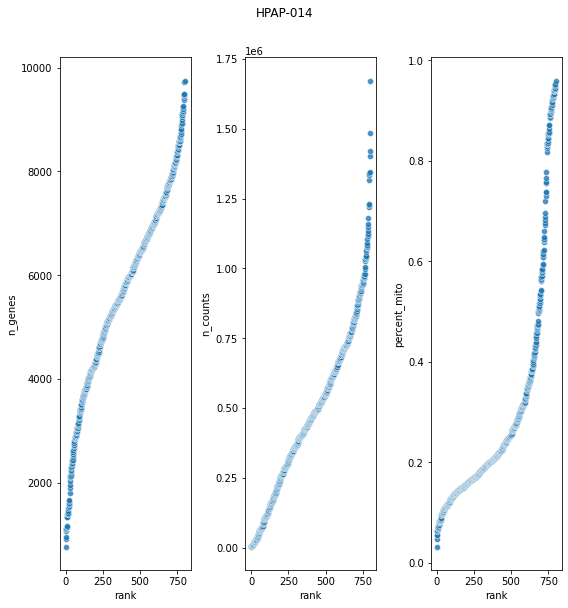

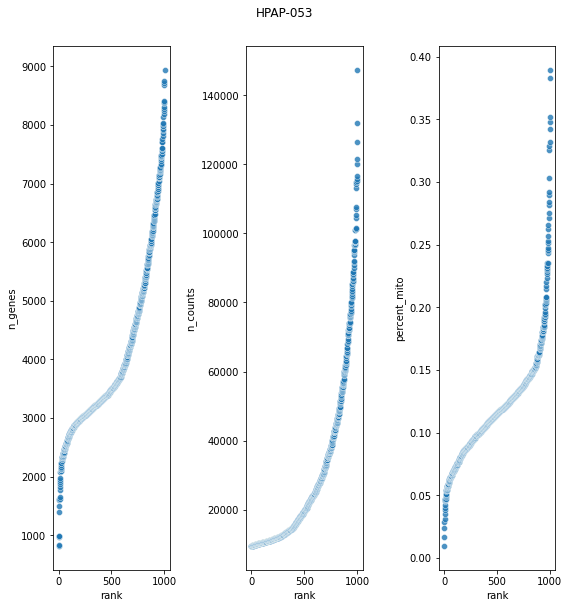

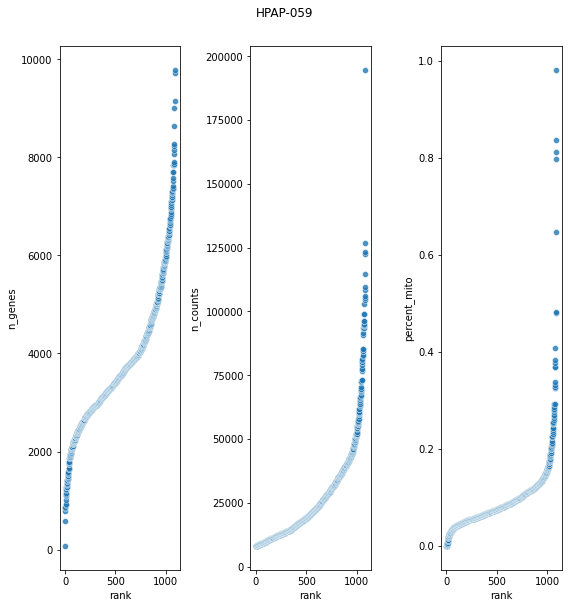

<Figure size 576x576 with 0 Axes>

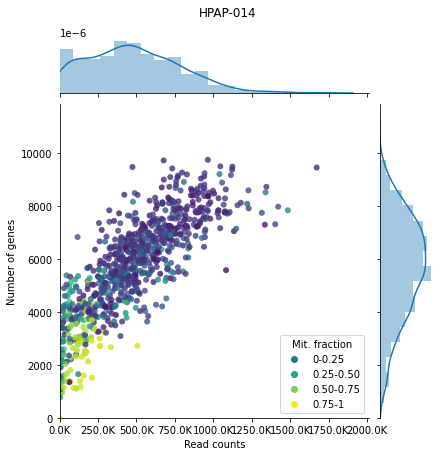

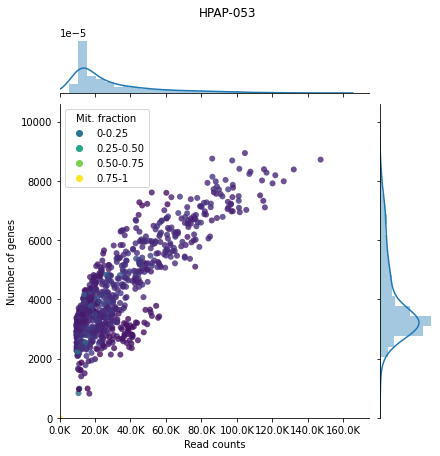

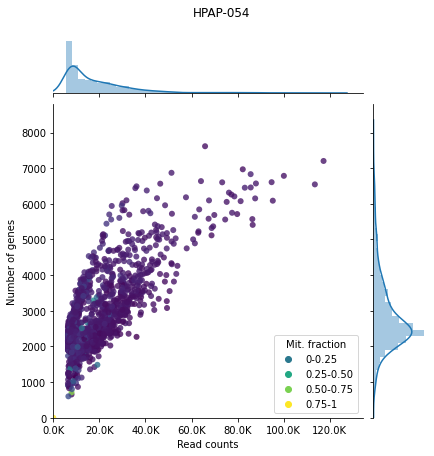

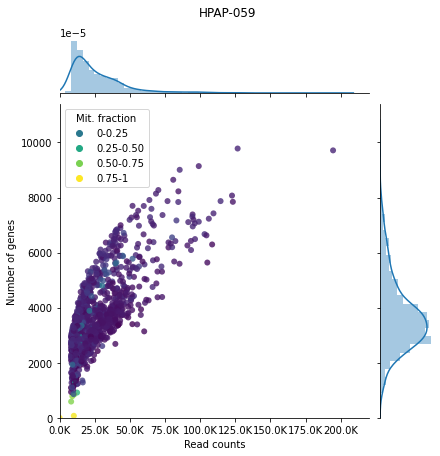

In [18]:
adatas_t2dnd = adatas_fluidigm_t2dnd + adatas_10X_t2dnd
ids_t2dnd = ids_fluidigm + ids_10X
allPlots(adatas_t2dnd,ids_t2dnd,prefix="figures/QC/ND.T2D",nFluidigm=2)